In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_path = '/content/drive/MyDrive/IMDB Dataset.csv'

In [3]:
import os
import pandas as pd
import numpy as np
import nltk
import csv
import math
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from nltk.tokenize import PunktSentenceTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.probability import FreqDist
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = pd.read_csv(data_path)
df.shape

(50000, 2)

In [5]:
#Q1
import re
import string

def preprocess(text):
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('<[^>]+>', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text


In [6]:
df['review']=df['review'].apply(preprocess)
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there s a family where a little boy ...,negative
4,petter mattei s love in the time of money is...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic di...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i m going to have to disagree with the previou...,negative


In [7]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(line):
    word_tokens = word_tokenize(line)
    return [w for w in word_tokens if not w in stop_words]

df['review'] = df['review'].apply(remove_stopwords)
df

    

,review,sentiment
0,"[one, reviewers, mentioned, watching, oz, epis...",positive
1,"[wonderful, little, production, filming, techn...",positive
2,"[thought, wonderful, way, spend, time, hot, su...",positive
3,"[basically, family, little, boy, jake, thinks,...",negative
4,"[petter, mattei, love, time, money, visually, ...",positive
...,...,...
49995,"[thought, movie, right, good, job, creative, o...",positive
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...",negative
49997,"[catholic, taught, parochial, elementary, scho...",negative
49998,"[going, disagree, previous, comment, side, mal...",negative


In [8]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def stemming_and_lemmatize(line):
    line = [lemmatizer.lemmatize(w) for w in line ]
    return [ps.stem(w) for w in line ]
df['review'] = df['review'].apply(stemming_and_lemmatize)
df

,review,sentiment
0,"[one, review, mention, watch, oz, episod, hook...",positive
1,"[wonder, littl, product, film, techniqu, unass...",positive
2,"[thought, wonder, way, spend, time, hot, summe...",positive
3,"[basic, famili, littl, boy, jake, think, zombi...",negative
4,"[petter, mattei, love, time, money, visual, st...",positive
...,...,...
49995,"[thought, movi, right, good, job, creativ, ori...",positive
49996,"[bad, plot, bad, dialogu, bad, act, idiot, dir...",negative
49997,"[cathol, taught, parochi, elementari, school, ...",negative
49998,"[go, disagre, previou, comment, side, maltin, ...",negative


In [9]:
def convert_sentiment_to_int(text):  #Convert sentiment positive to 1, negative to 0
    if(text.lower() == 'positive'):
        text = 1
    else:
        text = 0
    return text

df['sentiment'] = df['sentiment'].apply(lambda x: convert_sentiment_to_int(x))
df

,review,sentiment
0,"[one, review, mention, watch, oz, episod, hook...",1
1,"[wonder, littl, product, film, techniqu, unass...",1
2,"[thought, wonder, way, spend, time, hot, summe...",1
3,"[basic, famili, littl, boy, jake, think, zombi...",0
4,"[petter, mattei, love, time, money, visual, st...",1
...,...,...
49995,"[thought, movi, right, good, job, creativ, ori...",1
49996,"[bad, plot, bad, dialogu, bad, act, idiot, dir...",0
49997,"[cathol, taught, parochi, elementari, school, ...",0
49998,"[go, disagre, previou, comment, side, maltin, ...",0


In [10]:
# number of docs positive:
pos = df.loc[df["sentiment"]== 1]
print(len(pos))
# number of docs negative:
neg = df.loc[df["sentiment"]== 0]
print(len(neg))

25000
25000


In [11]:
import matplotlib
from matplotlib import pyplot as plt
bigram_vectorizer = CountVectorizer(ngram_range=(1,2),token_pattern=r'\b\w+\b', min_df=1)
analyze = bigram_vectorizer.build_analyzer()
# fdist = FreqDist()

#count terms for eath category
def uni_and_bi_gram(review):
    join = " "
    for ele in review:  
        join += " " + ele 
    return analyze(join)

#create fdist of all the terms uni and bi gram
def make_uni_bi_gram_fdist(reviews,dist):
  for review in reviews:
    for term in review:
      dist[term.lower()]+=1

#Distribution per category###
def distribution_plot(dct, num_of_terms, max_appearance, bins_cut,  title, unigram):
  new_dct = {}
  if unigram:
    for k,v in dct.items():
      if ' ' not in k: new_dct[k] = v
  else:
    for k,v in dct.items():
      if ' ' in k: new_dct[k] = v
  
  apperances_list =sorted(list(new_dct.values()))
  appereances_df = pd.DataFrame({'Num of appeareances': [value for value in apperances_list if value<=max_appearance]})
  bins = pd.cut(appereances_df['Num of appeareances'], [i for i in range(max_appearance+1)  if i%bins_cut == 0])
  appereances_df = (appereances_df.groupby(bins)['Num of appeareances'].agg(['count'])).reset_index()
  appereances_df.plot(x='Num of appeareances', y='count', kind='bar', stacked=True, width=0.5)
  plt.xlabel("Num of appeareances")
  plt.ylabel("Num of terms")
  plt.title(title)
  plt.show()

In [12]:
uni_and_bi= pos['review'].apply(uni_and_bi_gram)
pos_all_terms=FreqDist()
make_uni_bi_gram_fdist(uni_and_bi,pos_all_terms)

#show top 10 of positive category
pos_df=pd.DataFrame()
pos_df["term"] = pos_all_terms.keys()
pos_df["frequency"]=pos_all_terms.values()
pos_df=pos_df.sort_values(by=['frequency'], ascending=False)
pos_df[:10]

,term,frequency
295,film,50874
599,movi,44832
0,one,28280
813,like,20555
299,time,16622
647,good,15257
318,see,15134
790,stori,14186
457,charact,14020
661,make,13809


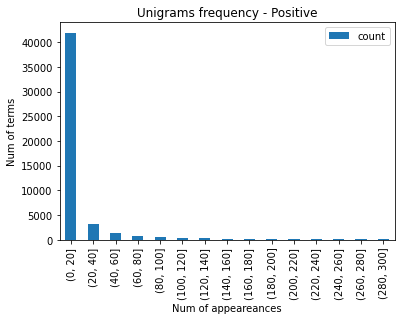

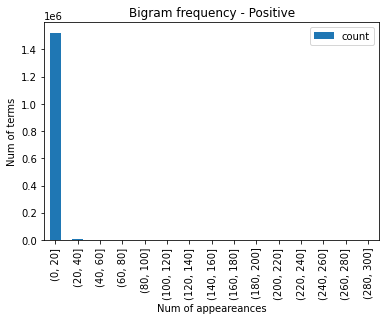

In [13]:
#show distribute to the uni grams- Positive
distribution_plot(pos_all_terms, len(pos_all_terms), 300, 20, 'Unigrams frequency - Positive', True)
#show distribute to the bi grams- Positive
distribution_plot(pos_all_terms, len(pos_all_terms), 300, 20, 'Bigram frequency - Positive', False)

In [14]:
#do tha same thing to negative category
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),token_pattern=r'\b\w+\b', min_df=1)
analyze = bigram_vectorizer.build_analyzer()

#show top 10 of negative category
uni_and_bi= neg['review'].apply(uni_and_bi_gram)
neg_all_terms=FreqDist()
make_uni_bi_gram_fdist(uni_and_bi,neg_all_terms)

#show top 10 of positive category
neg_df=pd.DataFrame()
neg_df["term"] = neg_all_terms.keys()
neg_df["frequency"]=neg_all_terms.values()
neg_df=neg_df.sort_values(by=['frequency'], ascending=False)
neg_df[:10]

,term,frequency
11,movi,58399
24,film,44975
160,one,27150
31,like,24640
23,make,16207
587,even,15429
10,time,15326
697,get,15269
41,watch,14965
679,good,14922


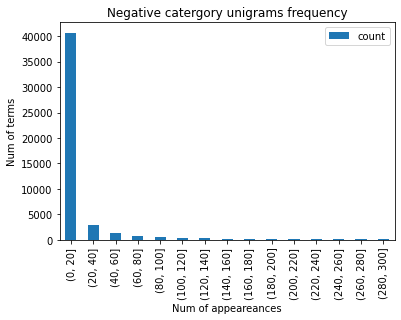

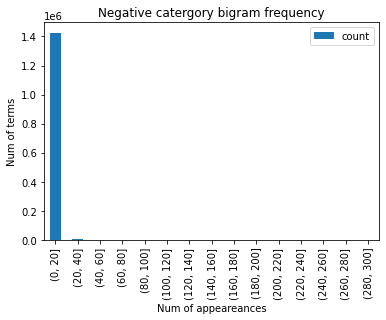

In [15]:
#show distribute to the uni grams- Positive
distribution_plot(neg_all_terms, len(neg_all_terms), 300, 20, 'Negative catergory unigrams frequency', True)
#show distribute to the bi grams- Positive
distribution_plot(neg_all_terms, len(neg_all_terms), 300, 20, 'Negative catergory bigram frequency', False)

In [16]:
y=df['sentiment']
x=df['review']
x = x.apply(lambda x: " ".join(x))
x

0        one review mention watch oz episod hook right ...
1        wonder littl product film techniqu unassum old...
2        thought wonder way spend time hot summer weeke...
3        basic famili littl boy jake think zombi closet...
4        petter mattei love time money visual stun film...
                               ...                        
49995    thought movi right good job creativ origin fir...
49996    bad plot bad dialogu bad act idiot direct anno...
49997    cathol taught parochi elementari school nun ta...
49998    go disagre previou comment side maltin one sec...
49999    one expect star trek movi high art fan expect ...
Name: review, Length: 50000, dtype: object

In [17]:
#split to test, train
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.5)

In [18]:
# Q2- sentiment analysis
import nltk
from nltk.corpus import sentiwordnet as swn
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')

def unsupervised_prediction(line):
    sentences = nltk.sent_tokenize(line)
    stokens = [nltk.word_tokenize(sent) for sent in sentences]
    taggedlist=[]

    #stoken: tokens for one sentence. Create POS tagging for each token
    for stoken in stokens:        
         taggedlist.append(nltk.pos_tag(stoken))
    wnl = nltk.WordNetLemmatizer()
    score_list=[]
    for idx,taggedsent in enumerate(taggedlist):  #iterate over all tokens
        score_list.append([])
        for idx2,t in enumerate(taggedsent):  #t[0] word, t[1] pos tag
#             print(t)
            newtag=''
            lemmatized=wnl.lemmatize(t[0])
            if t[1].startswith('NN'):
                newtag='n'
            elif t[1].startswith('JJ'):
                newtag='a'
            elif t[1].startswith('V'):
                newtag='v'
            elif t[1].startswith('R'):
                newtag='r'
            else:
                newtag=''       
            if(newtag!=''):    
                synsets = list(swn.senti_synsets(lemmatized, newtag))
                #synsets contains for each token the probability for negative, positive and objective
                #Getting average of all possible sentiments, as you requested        
                score=0
                if(len(synsets)>0):
                    for syn in synsets:
#                         print("positive score ",syn.pos_score(),"negative score ",syn.neg_score(),"objective score ",syn.obj_score())
                        score+=syn.pos_score()-syn.neg_score()
                    score_list[idx].append(score/len(synsets))
    sentence_sentiment=[]
    for score_sent in score_list:
        sentence_sentiment.append(sum([word_score for word_score in score_sent])/len(score_sent))
        
    review_sentiment = sum([word_score for word_score in sentence_sentiment])/len(sentence_sentiment)
    
    if review_sentiment>0:
        return 1
    else: return 0
    
sentiment_predictions=[]
for review in x_test.values:
    sentiment_predictions.append(unsupervised_prediction(review))         

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [19]:
#to calculate accuracy of unsupervised model
print("unsupervised:")
print(classification_report(y_test, sentiment_predictions, labels=[0, 1]))

unsupervised:
              precision    recall  f1-score   support

           0       0.72      0.45      0.56     12561
           1       0.60      0.82      0.69     12439

    accuracy                           0.63     25000
   macro avg       0.66      0.64      0.62     25000
weighted avg       0.66      0.63      0.62     25000



In [20]:
#Q3

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, Perceptron

In [22]:
#CountVectorizer

In [23]:
# Test the impact of changing ngram_range paramenter 
#features exraction method -CountVectorizer  + NGRAM=3
countVectorizer = CountVectorizer( max_df=0.5,stop_words='english', ngram_range=(1, 3), lowercase=True,binary=True)
X_train_CV = countVectorizer.fit_transform(x_train)
X_test_CV = countVectorizer.transform(x_test)

In [24]:
print("Using features exraction method - CountVectorizer + NGRAM=3 :")
#create and predict MultinomialNB model
naive_bayes = MultinomialNB(fit_prior=False)
naive_bayes.fit(X_train_CV, y_train)
y_pred_naive_bayes = naive_bayes.predict(X_test_CV)
print(f"naive_bayes Accuracy:")
print(classification_report(y_test, y_pred_naive_bayes, labels=[0, 1]))

Using features exraction method - CountVectorizer + NGRAM=3 :
naive_bayes Accuracy:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     12561
           1       0.87      0.87      0.87     12439

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [25]:
#create and predict SVM model
svm = SGDClassifier(max_iter=1500)
svm.fit(X_train_CV, y_train)
y_pred_svm = svm.predict(X_test_CV)
print(f"SVM Accuracy:")
print(classification_report(y_test, y_pred_svm, labels=[0, 1]))


SVM Accuracy:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     12561
           1       0.88      0.89      0.88     12439

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [26]:
#create and predict Perceptron model
perceptron = Perceptron(n_iter_no_change=6)
perceptron.fit(X_train_CV, y_train)
y_pred_perceptron = perceptron.predict(X_test_CV)
print(f"Perceptron Accuracy:")
print(classification_report(y_test, y_pred_perceptron, labels=[0, 1]))

Perceptron Accuracy:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12561
           1       0.88      0.88      0.88     12439

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [27]:
# TfidfVectorizer

In [28]:
#features exraction method - TF-IDF + NGRAM=3
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.55,
                                 stop_words='english', ngram_range=(1, 3), lowercase=True)
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)

In [29]:
print("Using features exraction method - TF-IDF + NGRAM=3 :")
import time
t0=time.time()
#create and predict MultinomialNB model
naive_bayes = MultinomialNB(alpha=0.1)
naive_bayes.fit(X_train, y_train)
y_pred_naive_bayes = naive_bayes.predict(X_test)
print(f"naive_bayes Accuracy:")
print(classification_report(y_test, y_pred_naive_bayes, labels=[0, 1]))
print(f"total time: {time.time()-t0}")

Using features exraction method - TF-IDF + NGRAM=3 :
naive_bayes Accuracy:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12561
           1       0.87      0.88      0.88     12439

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

total time: 0.5719869136810303


In [30]:
t0=time.time()
#create and predict SVM model
svm = SGDClassifier(alpha=0.000001)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print(f"SVM Accuracy:")
print(classification_report(y_test, y_pred_svm, labels=[0, 1]))
print(f"total time: {time.time()-t0}")

SVM Accuracy:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     12561
           1       0.88      0.90      0.89     12439

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

total time: 0.9198310375213623


In [31]:
t0=time.time()
#create and predict Perceptron model
perceptron = Perceptron(alpha=0.1)
perceptron.fit(X_train, y_train)
y_pred_perceptron = perceptron.predict(X_test)
print(f"Perceptron Accuracy:")
print(classification_report(y_test, y_pred_perceptron, labels=[0, 1]))
print(f"total time: {time.time()-t0}")

Perceptron Accuracy:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     12561
           1       0.87      0.89      0.88     12439

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

total time: 0.7617003917694092


In [32]:
#Q4

In [33]:
# create feature from unsupervise model to train and test sets
pred_train=[]
for review in x_train.values:
    pred_train.append(unsupervised_prediction(review))   

In [34]:
#create column to be added to the vectorizer mztrix
pred_train_add=[[pred] for pred in pred_train]

In [35]:
# predict on the test set
pred_test=[]
for review in x_test.values:
    pred_test.append(unsupervised_prediction(review))   

In [36]:
#create column to be added to the vectorizer mztrix
pred_test_add=[[pred] for pred in pred_test]

In [37]:
#features exraction method - TF-IDF + NGRAM=3
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.55,
                                 stop_words='english', ngram_range=(1, 3))
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)


In [38]:
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import FeatureUnion
from scipy.sparse import coo_matrix, hstack

#add the new feature to the train and to the test features respectively
x_train_tfidf_coo=coo_matrix(x_train_tfidf)
x_train_tfidf_coo_final = hstack([x_train_tfidf_coo,pred_train_add])

x_test_tfidf_coo=coo_matrix(x_test_tfidf)
x_test_tfidf_coo_final = hstack([x_test_tfidf_coo,pred_test_add])

In [39]:
# now we choose the supervise model SVM as this is the best supervise model for this data 
svm = SGDClassifier(alpha=0.000001)
svm.fit(x_train_tfidf_coo_final, y_train)
y_pred_svm = svm.predict(x_test_tfidf_coo_final)
print(f"SVM Accuracy:")
print(classification_report(y_test, y_pred_svm, labels=[0, 1]))

SVM Accuracy:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     12561
           1       0.89      0.89      0.89     12439

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

